In [1]:
import os
os.environ['TF_CP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import pickle

GPU setting. It isn't neccessary in CoLab.

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
with open('/content/drive/MyDrive/5-mer_data/009.1.mid.position.base.array.pkl', 'rb') as file:
    y_arr =pickle.load(file)
with open('/content/drive/MyDrive/5-mer_data/009.2.5mer.feature.pkl', 'rb') as file:
    x_arr_3d = pickle.load(file)
print(y_arr.shape)
print(x_arr_3d.shape)

(214966, 5)
(214966, 5, 7)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

x_arr_3d, y_arr = shuffle(x_arr_3d, y_arr, random_state= 42)

X_train_temp, X_test, y_train_temp, y_test = train_test_split(x_arr_3d, y_arr,
                                                    test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp,
                                                    test_size=0.11, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(172187, 5, 7)
(172187, 5)
(21497, 5, 7)
(21497, 5)
(21282, 5, 7)
(21282, 5)


In [4]:
from sklearn.utils import class_weight

y_train_labels= np.where(y_train==1)[1]
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(0.7706702472865615), 1: np.float64(1.5044735692442115), 2: np.float64(0.7898667400628455), 3: np.float64(1.0511705991880589), 4: np.float64(1.2189367124451367)}


In [ ]:
model = keras.Sequential([
    # tf.keras.Input()-- instantiate a Keras tensor
    # In TensorFlow Keras, input layers are essential for defining the expected
    # shape and data type of input data for a neural network. There are two primary
    #  ways to define input layers: keras.Input and keras.layers.InputLayer.
    # --keras.Input: This approach is often favored for its conciseness and flexibility,
    #  especially when building models using the Functional API. It directly creates a
    # symbolic tensor-like object representing the input.
    # Define an input layer for a sequence of 5 time steps with 7 features each
    # None for batch size
    keras.Input(shape = (5,7), dtype = "float32"),
    layers.Bidirectional(layers.GRU(units=128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units=128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units=128)),
    layers.Dense(units = 5, activation='softmax')
])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 5, 256)         │       105,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 5, 256)         │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,397 (2.67 MB)

 Trainable params: 699,397 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0005),
              # If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss
              # from_logits in keras.losses.CategoricalCrossentropy should be set to True when the
              # output of your model's last layer has not passed through a softmax
              # activation function.
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction='sum_over_batch_size',
                    name='categorical_crossentropy'
                  ),
              loss_weights = None,
              metrics=['categorical_accuracy', 'precision', 'recall',
                       keras.metrics.AUC(name='prc', curve='PR')])

In [ ]:
# using early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


history = model.fit(X_train, y_train,
          batch_size = 128,
          # An epoch, in Machine Learning, is the entire processing
          # by the learning algorithm of the entire train-set.
          epochs = 30,
          class_weight = class_weights_dict,
          callbacks = [early_stopping],
          validation_data = (X_val, y_val),
          verbose = 2)

Epoch 1/30
1346/1346 - 20s - 15ms/step - categorical_accuracy: 0.8493 - loss: 0.3935 - prc: 0.9471 - precision: 0.8876 - recall: 0.8204 - val_categorical_accuracy: 0.9059 - val_loss: 0.2092 - val_prc: 0.9741 - val_precision: 0.9078 - val_recall: 0.9040
Epoch 2/30
1346/1346 - 15s - 11ms/step - categorical_accuracy: 0.9241 - loss: 0.2329 - prc: 0.9802 - precision: 0.9253 - recall: 0.9229 - val_categorical_accuracy: 0.9339 - val_loss: 0.1673 - val_prc: 0.9832 - val_precision: 0.9347 - val_recall: 0.9330
Epoch 3/30
1346/1346 - 15s - 11ms/step - categorical_accuracy: 0.9348 - loss: 0.2073 - prc: 0.9837 - precision: 0.9356 - recall: 0.9339 - val_categorical_accuracy: 0.9364 - val_loss: 0.1620 - val_prc: 0.9843 - val_precision: 0.9371 - val_recall: 0.9359
Epoch 4/30
1346/1346 - 15s - 11ms/step - categorical_accuracy: 0.9403 - loss: 0.1924 - prc: 0.9858 - precision: 0.9412 - recall: 0.9396 - val_categorical_accuracy: 0.9364 - val_loss: 0.1632 - val_prc: 0.9840 - val_precision: 0.9370 - val_rec

In [ ]:
model.evaluate(X_test, y_test,
               batch_size = 128,
               verbose = 2)
#model.metrics_names

168/168 - 1s - 5ms/step - categorical_accuracy: 0.9441 - loss: 0.1446 - prc: 0.9867 - precision: 0.9448 - recall: 0.9430


[0.14460375905036926,
 0.9440852403640747,
 0.9448147416114807,
 0.9429687857627869,
 0.9867428541183472]

In [6]:
## confusion matrix
labels= np.where(y_test==1)[1]
print(labels)
def softmax_to_label(softmax_output):
  """Converts softmax probabilities to a label encoded value.

  Args:
    softmax_output: A list or numpy array of probabilities.

  Returns:
    The index of the highest probability.
  """
  return np.argmax(softmax_output)
predictions = model.predict(X_test)


[0 2 4 ... 2 3 2]
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


In [7]:
predictions_label = np.apply_along_axis(softmax_to_label,  1, predictions)
print(len(predictions_label))
confusion_matrix = tf.math.confusion_matrix(labels,
                                           predictions_label,
                                           num_classes=5)

# Print the confusion matrix
print(confusion_matrix.numpy())

21497
[[5542    7   11    4    5]
 [   5 2299    4    4  605]
 [   3    7 5391    6    5]
 [  10    7    7 4042    6]
 [   7  484    9    5 3022]]


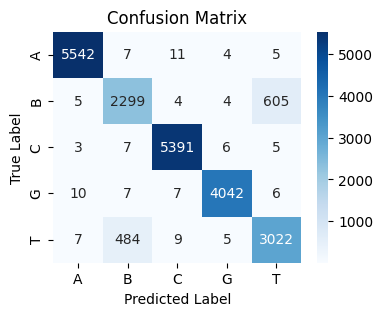

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ["A","B", "C", "G", "T"]
def plot_confusion_matrix(cm, class_names, outfilename):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(outfilename)
    plt.show()

outfilename = '/content/drive/MyDrive/5-mer_data/Figure000.syn.5mers.only-20250710-1412.confusion.matrix.pdf'
plot_confusion_matrix(confusion_matrix.numpy(), class_names, outfilename)
# Evaluate the confusion matrix within a TensorFlow session or eager context
# with tf.compat.v1.Session() as sess:
#     np_cm = sess.run(confusion_matrix)
#     plot_confusion_matrix(np_cm, class_names)

In [ ]:
my_drive = '/content/drive/MyDrive'
out_dir = os.path.join(my_drive, "5-mer_data")

## human HK293 cells cultured in BrdU-supplemented media (~20% BrdU subtitution rate by Mass Spectrometry)
brdu_dir = os.path.join(my_drive, "5-mer_data/barcode02")
pickle_files = os.listdir(brdu_dir)

brdu_perc_human_BrdU = {}
for p in pickle_files:
  with open(f'{brdu_dir}/{p}', 'rb') as file:
    X_test = pickle.load(file)
    predictions = model.predict(X_test, verbose=0)

    predictions_labels = np.apply_along_axis(softmax_to_label,  1, predictions)
    BrdU_percentage = np.sum(predictions_labels==1)/len(predictions_labels)
    #print(BrdU_percentage)
    brdu_perc_human_BrdU[p] = BrdU_percentage
with open(os.path.join(out_dir, '5mer.human.HK293.brdu.perc-syntheetic.5mer.only.model.pkl'), 'wb') as file:
  pickle.dump(brdu_perc_human_BrdU, file)

In [ ]:
model.save('/content/drive/MyDrive/000_DeepBrdU.trained.w.syn.5mers.only-20250710-1412.keras')

In [ ]:
## mouse cell cultured in BrdU-free media
t_dir = os.path.join(my_drive, "5-mer_data/barcode01")
pickle_files = os.listdir(t_dir)

brdu_perc_mouse_T = {}
for p in pickle_files:
  with open(f'{t_dir}/{p}', 'rb') as file:
    X_test = pickle.load(file)
    predictions = model.predict(X_test, verbose=0)

    predictions_labels = np.apply_along_axis(softmax_to_label,  1, predictions)
    BrdU_percentage = np.sum(predictions_labels==1)/len(predictions_labels)
    #print(BrdU_percentage)
    brdu_perc_mouse_T[p] = BrdU_percentage
print(brdu_perc_mouse_T)
with open(os.path.join(out_dir,
                       '5mer.mouse.brdu-free.perc-syntheetic.5mer.only.model.pkl'), 'wb') as file:
  pickle.dump(brdu_perc_mouse_T, file)

{'ee283b82-24da-4279-bc7f-556f1cd55796.fast5.resquiggle.features.txt.pkl': np.float64(0.22418478260869565), 'ee298f05-8efc-46cd-a5dc-2e83a73626a8.fast5.resquiggle.features.txt.pkl': np.float64(0.20270270270270271), 'a24605b6-5e79-4ac0-a9f6-bba203b94667.fast5.resquiggle.features.txt.pkl': np.float64(0.23626153229041316), 'c6f803d7-5610-4735-8fdb-eb7a38380883.fast5.resquiggle.features.txt.pkl': np.float64(0.32155205532078374), 'ee2f9a92-89a2-4bac-881b-09fbeb9e2456.fast5.resquiggle.features.txt.pkl': np.float64(0.24857685009487665), 'd86cd304-665c-4ec2-9c99-ac9c4fa9c8ff.fast5.resquiggle.features.txt.pkl': np.float64(0.258431985704713), 'd88f581e-e8b4-4b1b-86da-7b408273e96d.fast5.resquiggle.features.txt.pkl': np.float64(0.23148148148148148), 'ee486c2a-0774-404d-bab5-9922e9c5c292.fast5.resquiggle.features.txt.pkl': np.float64(0.2345258375922771), 'a2571010-38ba-428a-8e79-2df7b97a7d48.fast5.resquiggle.features.txt.pkl': np.float64(0.2676056338028169), 'b4b40dc8-441d-4a69-b5b1-4ae13e5f62cc.fa

In [14]:
my_drive = '/content/drive/MyDrive'
out_dir = os.path.join(my_drive, "5-mer_data")

with open(os.path.join(out_dir,
                       '5mer.mouse.brdu-free.perc-syntheetic.5mer.only.model.pkl'), 'rb') as file:
  brdu_perc_mouse_T = pickle.load(file)

with open(os.path.join(out_dir, '5mer.human.HK293.brdu.perc-syntheetic.5mer.only.model.pkl'), 'rb') as file:
  brdu_perc_human_BrdU = pickle.load(file)

brdu_perc_human_BrdU = pd.DataFrame.from_dict(brdu_perc_human_BrdU, orient='index')
brdu_perc_human_BrdU.columns = ['perc']

brdu_perc_mouse_T = pd.DataFrame.from_dict(brdu_perc_mouse_T, orient='index')
brdu_perc_mouse_T.columns = ['perc']

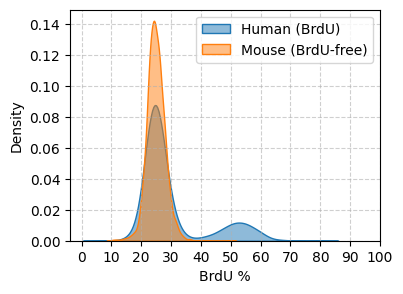

              perc
count  3486.000000
mean      0.299603
std       0.112323
min       0.070175
25%       0.233920
50%       0.257345
75%       0.295389
max       0.794118
              perc
count  3113.000000
mean      0.248789
std       0.030958
min       0.102041
25%       0.229959
50%       0.247204
75%       0.266812
max       0.500000


In [16]:
# Create the plot
%matplotlib inline

plt.figure(figsize=(4, 3))

# Plot the first density plot
sns.kdeplot(brdu_perc_human_BrdU['perc']*100, label='Human (BrdU)', fill=True, alpha=0.5)

# Plot the second density plot
sns.kdeplot(brdu_perc_mouse_T['perc']*100, label='Mouse (BrdU-free)', fill=True, alpha=0.5)

# Add labels and title
plt.xlabel('BrdU %')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# reset x-axis ticks
plt.xticks(np.array([0,  10,  20, 30, 40, 50, 60, 70, 80, 90, 100]))


# Show the plot
plt.savefig('/content/drive/MyDrive/5-mer_data/Figure000.syn.5mers.only-20250710-1412.predicting.mouse.human.pdf')
plt.show()
print(brdu_perc_human_BrdU.describe())
print(brdu_perc_mouse_T.describe())